# Práctica 3

Para esta practica se consideran las siguientes librerias:
- Funciones numéricas:  numpy y scipy
- Graficación, visualización y manipulación de imagenes: matplotlib y cv2
- Carga de archivos de audio: soundfile 


In [82]:
import os

import matplotlib.pyplot as plt
import cv2
import numpy as np
import scipy as sp
import soundfile as sf

from matplotlib import cm  # colour map
from scipy import signal  # spectrogram function
from scipy.signal import ShortTimeFFT as STFT, windows

## Punto 1: Compresión de Imágenes

En este punto se busca comprimir una imagen utilizando la transformada discreta coseno, eliminando los componentes que tienen poca energía, y reconstruyendo la imagen. 
Para empezar se carga una imagen conocida y se convierte a escala de grises

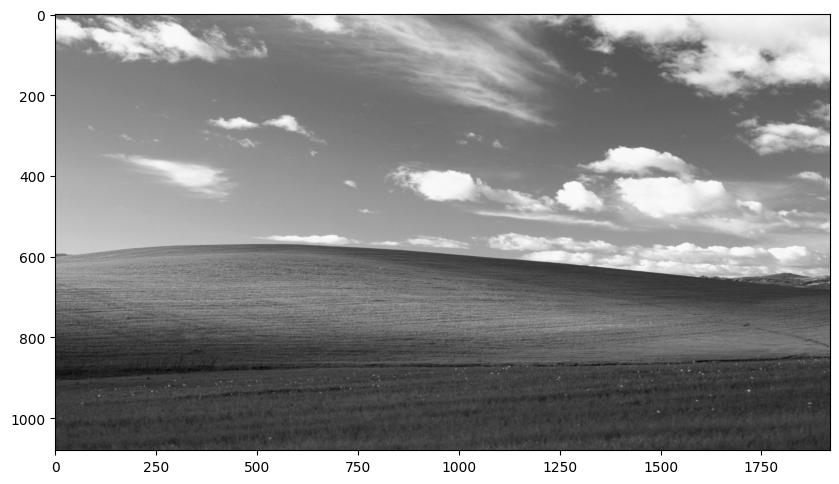

In [92]:
image = cv2.imread("./assets/bliss.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")

A continuación se guarda el array para verificar su tamaño en disco, se utiliza el comando "cv2.dct" que calcula la transformada coseno discreta en 2 dimensiones y en dicho arreglo se hacen 0 las componentes de la 100 en adelante, las cuales segun el gráfico de la energía estaban cercanas a 0.
Luego se guarda el array de la imagen con la dct aplicada en disco y se obtiene el tamaño de este para posteriormente reconstruir la imagen con la transformada inversa.    

Tamaño del archivo comprimido: 1.14 MB
Tamaño del archivo con dct: 0.41 MB


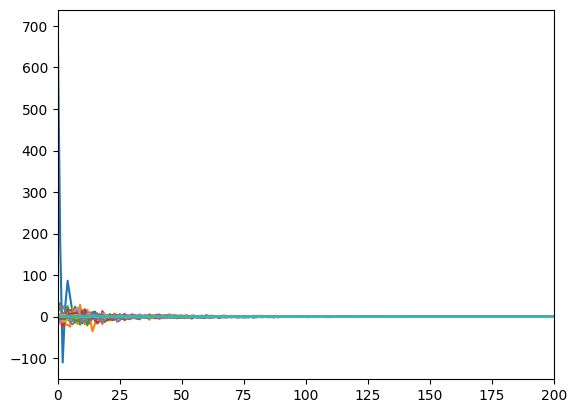

<Figure size 640x480 with 0 Axes>

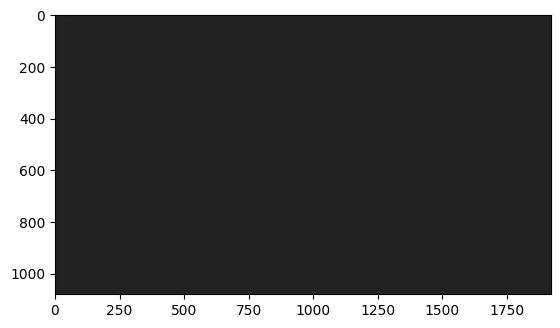

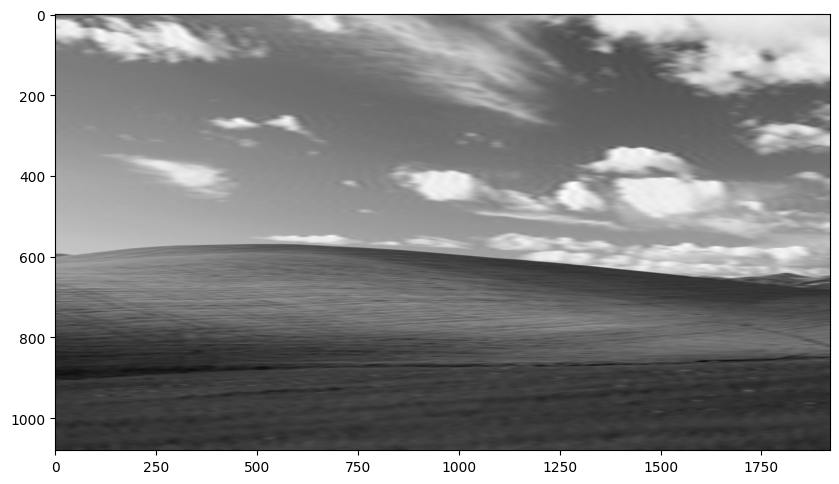

In [93]:
np.savez_compressed("array_sin_dct.npz", arr=image)


loaded_data = np.load("array_sin_dct.npz")
loaded_arr = loaded_data["arr"]


file_size = os.path.getsize("array_sin_dct.npz")
print(
    f"Tamaño del archivo comprimido: {file_size / (1024 * 1024):.2f} MB"
)  # Convertir bytes a MB

image_dct = cv2.dct(np.float32(image) / 255.0)
plt.plot(image_dct)
plt.xlim(0, 200)
plt.figure()
image_dct[:, 100:] = 0

np.savez_compressed("array_comprimido.npz", arr=image_dct)
loaded_data = np.load("array_comprimido.npz")
loaded_arr = loaded_data["arr"]


file_size = os.path.getsize("array_comprimido.npz")
print(f"Tamaño del archivo con dct: {file_size / (1024 * 1024):.2f} MB")


plt.figure()

plt.imshow(image_dct, cmap="gray")
plt.figure(figsize=(10, 10))
inverse = cv2.idct(image_dct) * 255.0
plt.imshow(inverse, cmap="gray")

Como puede observarse, el tamaño se redujo considerablemente de 1.14 MB a 0.41 MB, sin embargo puede observarse que en la imagen se pierden algunos detalles, la definición de las lineas se reduce, se eliminan las flores de la pradera y se tiene una perdida general de calidad. Sin embargo de forma general la imagen sigue siendo legible y se distingue claramente lo que contiene, por lo cual ofrece una alternatifa facil y rapida de reducir el tamaño de los archivos en disco. 


## Punto 2: Fase desenvuelta


Para este punto se plantea desenvolver la fase de un sistema arbitrario de la forma


Se selecciona inicialmente un filtro Chebyshev y se representa la respuesta en frecuencia del mismo.

<Figure size 640x480 with 0 Axes>

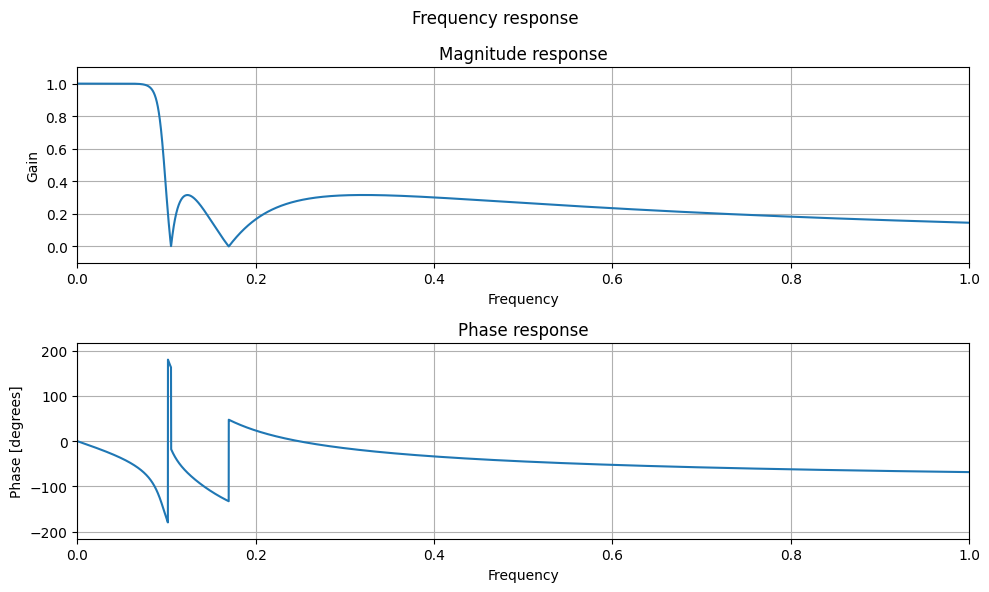

In [85]:
a_k = [1.0, -4.59548047, 8.45473341, -7.78156152, 3.58147828, -0.65912607]
b_k = [0.06863549, -0.20317289, 0.13455922, 0.13455922, -0.20317289, 0.06863549]

transfer_function = sp.signal.TransferFunction(b_k, a_k, dt=0.1)

w, H = sp.signal.dfreqresp(transfer_function, np.arange(0, 1, 0.0001))
angle = np.angle(H, deg=True)
plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")

ax[0].plot(w, abs(H))
ax[0].set_title("Magnitude response")
ax[0].set_xlabel("Frequency")
ax[0].set_xlim(0, 1)

ax[0].set_ylabel("Gain")
plt.margins(0, 0.1)

ax[1].plot(w, angle)
ax[1].set_title("Phase response")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Phase [degrees]")
ax[1].set_xlim(0, 1)

fig.tight_layout()

Como puede observarse, la fase y la magnitud presentan algunas discontinuidades, lo cual puede generar problemas a la hora de realizar cálculos como el retardo de grupo y además hace que sea complicado entender el sistema.

Se plantea desenvolver la fase utilizando la funcion de numpy unwrap que suma o resta 180° si se presenta una diferencia considerable en los valores anteriores. Además se calcula la derivada de la magnitud para encontrar cambios bruscos, los cuales se presentan en los cambios de signo de la magnitud. Teniendo esos puntos se multiplica por -1 dado el caso para obtener una gráfica de amplitud de la señal sin cambios fuertes.

<Figure size 640x480 with 0 Axes>

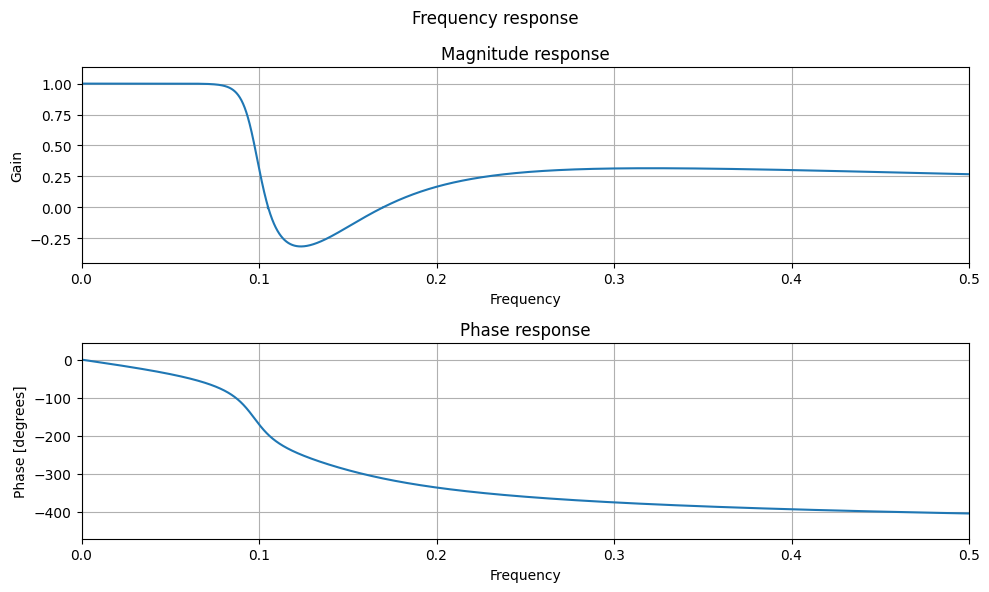

In [86]:
def find_discontinuities(arr, threshold):
    differences = np.abs(
        np.diff(arr)
    )  # Compute absolute differences between consecutive elements
    discontinuity_indices = np.where(differences > threshold)[
        0
    ]  # Find indices where differences exceed threshold
    return discontinuity_indices


angle_unwrapped = np.unwrap(np.angle(H, deg=True), period=180)

discontinuities = find_discontinuities(np.diff(abs(H)) / np.diff(w), 5)

multiple = np.ones_like(w)
for i in discontinuities[::2]:
    multiple[i:] *= -1

plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")

ax[0].plot(w, abs(H) * multiple)

ax[0].set_title("Magnitude response")
ax[0].set_xlabel("Frequency")
ax[0].set_xlim(0, 0.5)

ax[0].set_ylabel("Gain")
plt.margins(0, 0.1)

ax[1].plot(w, angle_unwrapped)
ax[1].set_title("Phase response")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Phase [degrees]")
ax[1].set_xlim(0, 0.5)

fig.tight_layout()

Y así se obtiene el gráfico con la fase desenvuelta lo que facilita la comprension del comportamiento del sistema permitiendo observar los cambios de la pendiente de la fase cerca a la frecuencia de corte del filtro, y se observa que ya las interrupciones de la grafica de magnitud han desaparecido y esta toma valores negativos.

Adicionalmente se realiza el mismo procedimiento con un filtro eliptico. Estos filtros tambien suelen presentar discontinuidades en la fase cuando no está desenvuelta.

<Figure size 640x480 with 0 Axes>

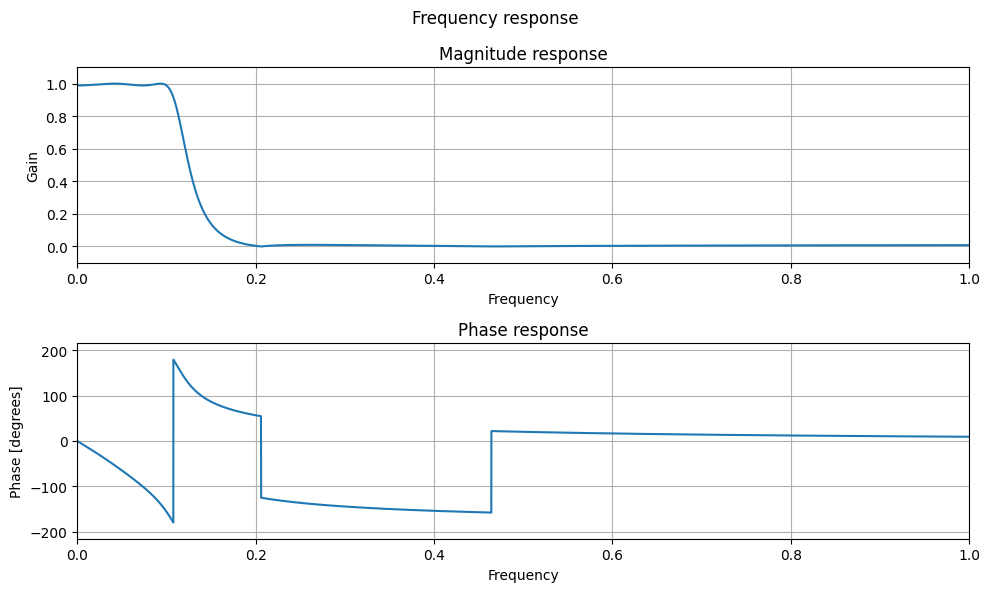

In [87]:
b_k, a_k = sp.signal.ellip(4, 0.1, 40, 0.1 / np.pi, output="ba")

transfer_function = sp.signal.TransferFunction(b_k, a_k, dt=0.1)

w, H = sp.signal.dfreqresp(transfer_function, np.arange(0, 1, 0.0001))
angle = np.angle(H, deg=True)
plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")

ax[0].plot(w, abs(H))
ax[0].set_title("Magnitude response")
ax[0].set_xlabel("Frequency")
ax[0].set_xlim(0, 1)

ax[0].set_ylabel("Gain")
plt.margins(0, 0.1)

ax[1].plot(w, angle)
ax[1].set_title("Phase response")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Phase [degrees]")
ax[1].set_xlim(0, 1)

fig.tight_layout()

Como se observa en la figura anterior, aunque la magnitud no presenta los cambios abruptos, la fase si presenta discontinuidades. Se realiza el mimso procedimiento con la funcion unwrap.

<Figure size 640x480 with 0 Axes>

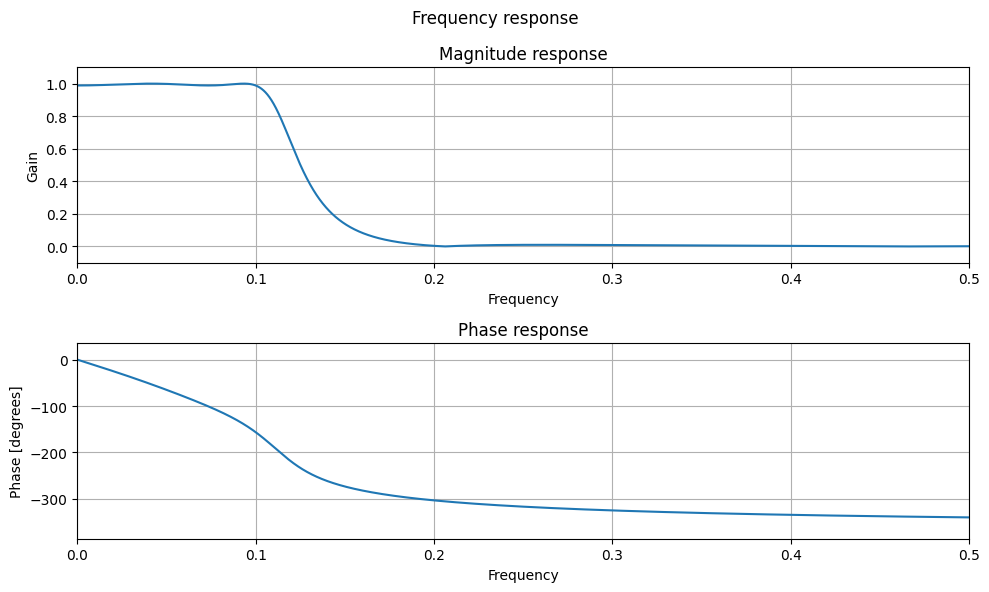

In [88]:
angle_unwrapped = np.unwrap(np.angle(H, deg=True), period=180)

discontinuities = find_discontinuities(np.diff(abs(H)) / np.diff(w), 5)

multiple = np.ones_like(w)
for i in discontinuities[::2]:
    multiple[i:] *= -1

plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")

ax[0].plot(w, abs(H) * multiple)

ax[0].set_title("Magnitude response")
ax[0].set_xlabel("Frequency")
ax[0].set_xlim(0, 0.5)

ax[0].set_ylabel("Gain")
plt.margins(0, 0.1)

ax[1].plot(w, angle_unwrapped)
ax[1].set_title("Phase response")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Phase [degrees]")
ax[1].set_xlim(0, 0.5)

fig.tight_layout()

Tal como se observa, la fase queda correctamente desenvuelta. Es importante tener en cuenta las unidades de la respuesta, algunos lenguajes o funciones pueden entregar el resultado en radianes, lo cual implica que el parametro de la funcion unwrap debe de cambiarse a pi y no a 180°.

# Retardo de grupo

Para este punto se plantea el calculo y la grafica del retardo de grupo sin utilizar funciones que lo calculen directamente. Para esto se considera un filtro Chebyshev 2 del cual se obtiene la funcion de transferencia con ceros y polos, se grafica la respuesta en frecuencia y para la fase se obtiene la derivada para obtener el retardo de grupo, siguiendo la formula

$$ \tau _g = -\frac{\delta\phi(\omega)}{\delta \omega} $$ 

<Figure size 640x480 with 0 Axes>

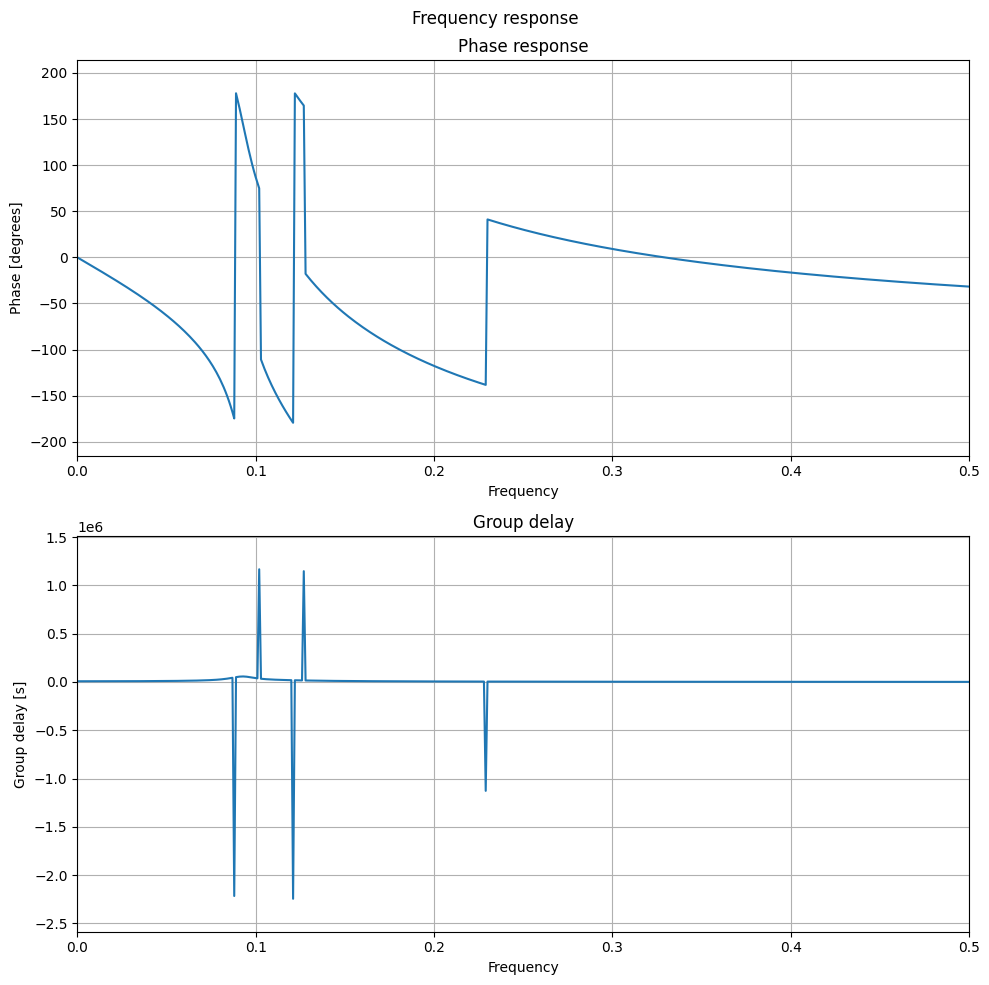

In [89]:
f_c = 0.1
z, p, k = sp.signal.cheby2(7, 20, Wn=f_c / np.pi, output="zpk")  # Chebyshev Type I
transfer_function = sp.signal.ZerosPolesGain(z, p, k, dt=0.01)
w, H = sp.signal.dfreqresp(transfer_function, np.arange(0, 1, 0.001))


angle = np.angle(H, deg=True)
plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")


ax[0].plot(w, angle)
ax[0].set_title("Phase response")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Phase [degrees]")
ax[0].set_xlim(0, 0.5)


derivative = -2 * np.pi * np.diff(angle) / np.diff(w)
ax[1].plot(w[:-1], derivative)
ax[1].set_title("Group delay")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Group delay")
ax[1].set_xlim(0, 0.5)

fig.tight_layout()

Como puede observarse, se presenta una situacion similar a la de los puntos anteriores, en la cual la fase presenta discontinuidades y al calcular la derivada de esta, los valores son atípicos y mucho mayores al resto del vector. Para solucionar esto se procede de manera similar, desenvolviendo la fase y calculando la derivada cuando esta esté desenvuelta.

<Figure size 640x480 with 0 Axes>

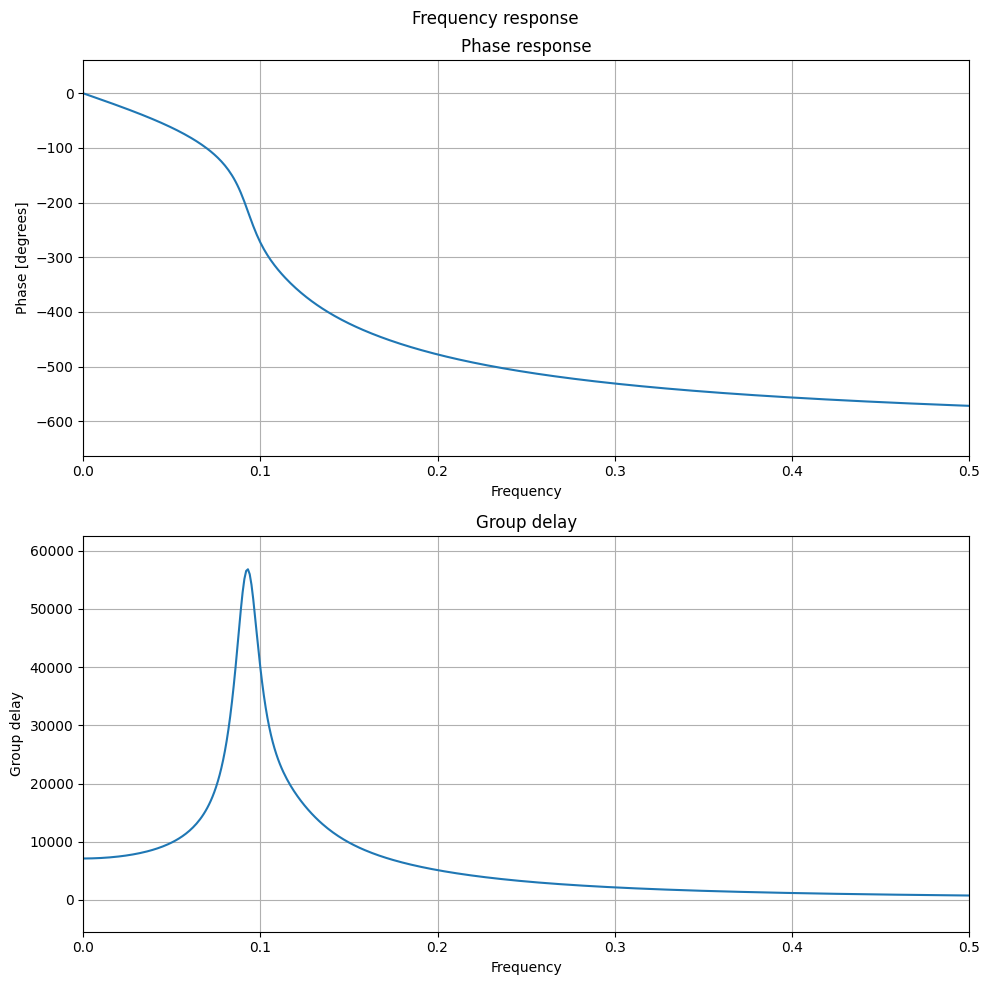

In [91]:
angle_unwrapped = np.unwrap(np.angle(H, deg=True), period=180)

discontinuities = find_discontinuities(np.diff(abs(H)) / np.diff(w), 15)


plt.figure()
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
for axis in ax:
    axis.grid()
    axis.margins(0, 0.1)
plt.suptitle("Frequency response")


ax[0].plot(w, angle_unwrapped)
ax[0].set_title("Phase response")
ax[0].set_xlabel("Frequency")
ax[0].set_ylabel("Phase [degrees]")
ax[0].set_xlim(0, 0.5)


derivative = -2 * np.pi * np.diff(angle_unwrapped) / (np.diff(w))
ax[1].plot(w[:-1], derivative)
ax[1].set_title("Group delay")
ax[1].set_xlabel("Frequency")
ax[1].set_ylabel("Group delay")
ax[1].set_xlim(0, 0.5)

fig.tight_layout()

Al calcular la derivada de la fase desenvuelta, se observa que la curva es suave y bien definida, y se observa que el retardo de grupo cerca a la frecuencia de corte del filtro presenta  un pico considerablemente mayor al del resto de los valores de frecuencia, lo que indica que se debe de tener especial cuidado con las frecuencias cercanas a la frecuencia de corte a la hora de calibrar retrasos u otros calculos derivados de la fase.

## Punto 4: Transformada de tiempo corto de Fourier

Para este punto se plantea realizar un espectrograma de una señal con el objetivo de ver como cambia su frecuencia con el tiempo. Para esto se utilizará la transformada de tiempo corto de Fourier. 
Se crea una señal de 10 segundos con las siguientes características:


- Los primeros 3 segundos se componen de una señal seno de frecuencia 2 kHz
- Del segundo 3 al 6, la frecuencia es de 4 kHz
- Del segundo 6 al 10 la frecuencia es de 1 kHz

Se establece una frecuencia de muestreo de 10 kHz, la cual es mayor que el doble de la frecuencia mas grande que se presenta en la señal para que se cumpla el criterio de Nyquist.
Posteriormente se instancia un objeto de la clase ShortTimeFFT de la libreria scipy, que se inicializa con una ventana tipo Hamming de 100 muestras, y se configura para que se desplace  dicha ventana sobre la señal 50 muestras cada iteración.
Luego se calcula la transformada de tiempo corto iterando por la señal con el método spectrogram de la clase ShortTimeFFT y se grafica la superficie respecto a los vectores correspondientes de frecuencia y de tiempo.



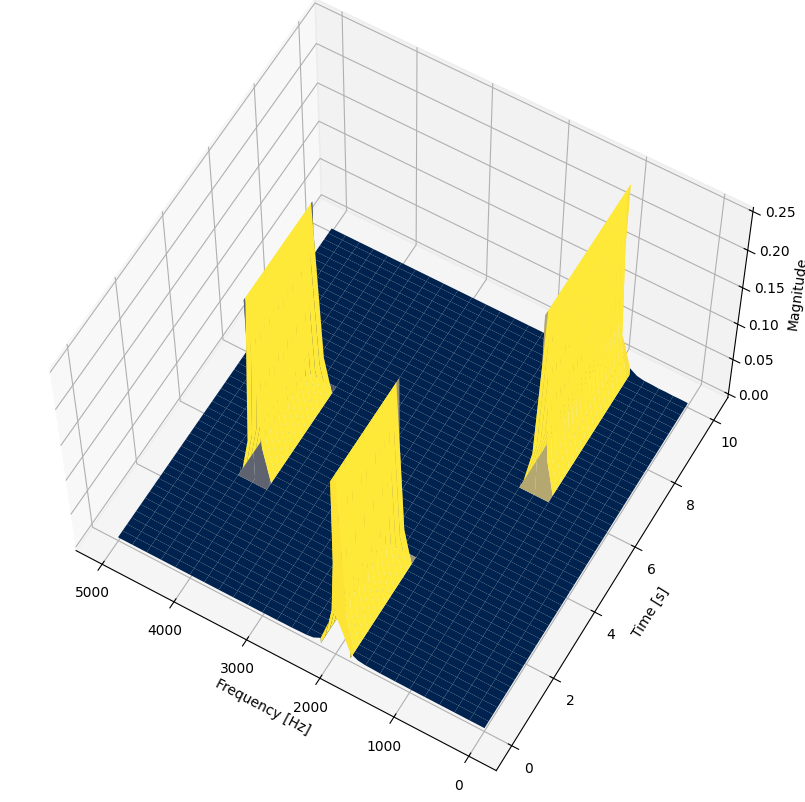

In [100]:
sample_rate = 10000  #
sig_len_secs = 10
frequency_1 = 2000.0
frequency_2 = 4000.0
frequency_3 = 1000

g_std = 8  # standard deviation for Gaussian window in samples
window = windows.hamming(100, sym=True)  # symmetric Gaussian window
N = sample_rate * sig_len_secs
stft = STFT(window, hop=50, fs=sample_rate, scale_to="magnitude")
timestamps_secs = np.arange(sample_rate * sig_len_secs) / sample_rate
t_lo, t_hi = stft.extent(N)[:2]

variable_frequency_signal = np.zeros_like(timestamps_secs)
variable_frequency_signal[0 : 3 * sample_rate] = np.sin(
    2 * np.pi * frequency_1 * timestamps_secs[0 : 3 * sample_rate]
)
variable_frequency_signal[3 * sample_rate : 6 * sample_rate] = np.sin(
    2 * np.pi * frequency_2 * timestamps_secs[3 * sample_rate : 6 * sample_rate]
)
variable_frequency_signal[6 * sample_rate :] = np.sin(
    2 * np.pi * frequency_3 * timestamps_secs[6 * sample_rate :]
)


result = stft.spectrogram(variable_frequency_signal)

f = np.linspace(0, sample_rate / 2, result.shape[0])
t = np.linspace(t_lo, t_hi, result.shape[1])

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(f[:, None], t[None, :], abs(result), cmap=cm.cividis)
ax.view_init(elev=60, azim=120)
ax.invert_yaxis()
ax.set_ylabel("Time [s]")
ax.set_xlabel("Frequency [Hz]")
ax.set_zlabel("Magnitude")
plt.show()

/tmp/ipykernel_920/1758084685.py:14: RuntimeWarning: divide by zero encountered in log10
  freq_bins[:, None], timestamps[None, :], 10.0 * np.log10(spec), cmap=cm.coolwarm


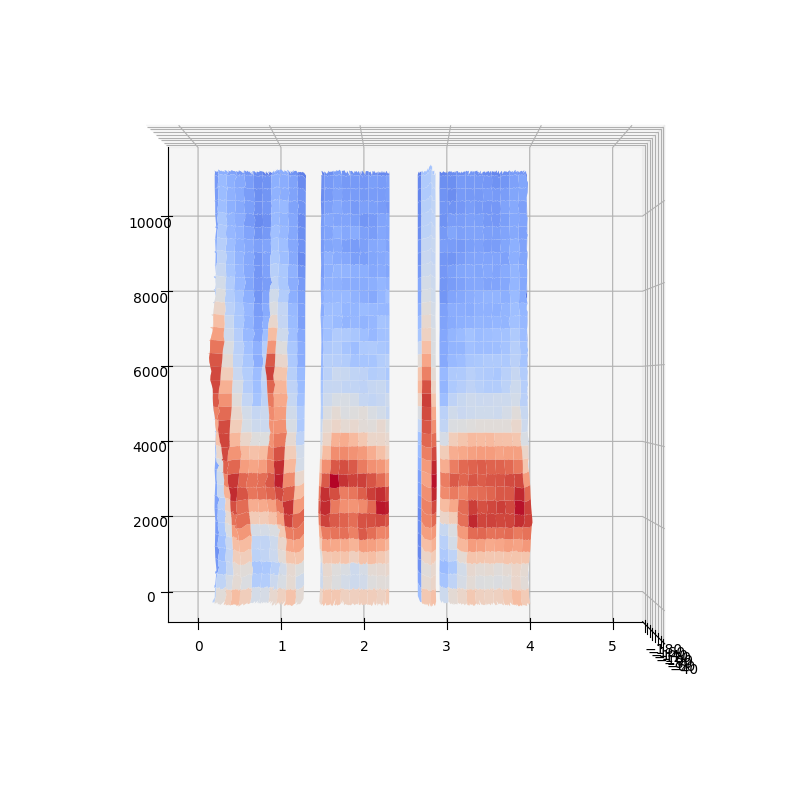

In [94]:
(audio_sample, fs) = sf.read("./assets/audio2.wav", dtype="float32")


freq_bins, timestamps, spec = signal.spectrogram(audio_sample[:, 1], fs, nperseg=200)

# 3d plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection="3d")
ax.plot_surface(
    freq_bins[:, None], timestamps[None, :], 10.0 * np.log10(spec), cmap=cm.coolwarm
)
ax.view_init(elev=90, azim=180)
ax.invert_yaxis()
plt.show()